In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import euclidean_distances
from scipy import optimize

from sklearn.model_selection import train_test_split

from scipy.io import savemat, loadmat

from sklearn.neighbors import KNeighborsClassifier
neigh = KNeighborsClassifier(n_neighbors=1)


with open('normal_pneumonia_train.npy', 'rb') as f:
    x_ray_features = np.load(f)
    x_ray_labels = np.load(f)

    
X_train, X_test, y_train, y_test = train_test_split(x_ray_features, x_ray_labels, 
                                                    test_size=2000, random_state=242)

classes = ['Normal', 'Pneumonia']

X_all = np.concatenate((X_train,X_test))

n = X_train.shape[0]

DPI = 400


print(x_ray_features.shape)
print(X_train.shape, y_train.shape, X_train.dtype, np.sum(y_train==0), np.sum(y_train==1))
print(X_test.shape, y_test.shape, X_test.dtype, np.sum(y_test==0), np.sum(y_test==1))
    
%matplotlib notebook

%load_ext autoreload
%autoreload 2

(13389, 1024)
(11389, 1024) (11389,) float32 6775 4614
(2000, 1024) (2000,) float32 1191 809


In [2]:
import numba
from numba import prange

@numba.jit(nopython=True, parallel=True)
def get_first_order_graph(X,n_neighbors):
    
    N = X.shape[0]
    
    dist = np.zeros((N, N), dtype=np.float32)
    #euclidean_distances(X_train, squared = False)

    sort_idx = np.zeros((N,n_neighbors), dtype=np.int32)
    
    for i in range(N):
        if (i+1)%10000 == 0:
            print('Completed ', i+1, ' of ', N)
        
        for j in prange(i+1,N):
            dist[i,j] = np.sum( (X[i]-X[j])**2 )
            dist[j,i] = dist[i,j]
        
        sort_idx[i,:] = np.argsort(dist[i,:])[1:n_neighbors+1]
    
    return sort_idx, dist

@numba.jit(nopython=True, parallel=True)
def my_trustworthiness(Y,sort_idx,K):
    N = Y.shape[0]

    val = 0.0
    for i in prange(N):
        dist = np.sum((Y - Y[i,:])**2,axis=1)
        
        #print(dist.shape)
        
        sort_idy = np.argsort(dist)[1:]
        for j in prange(K):
            r_0 = np.argwhere(sort_idy[j]==sort_idx[i,:])
            #print(i, r_0, sort_idx[i,j])
            #print(sort_idy)
            r = r_0[0,0] 
            #print(i,r)
            #print(sort_idx[i,j])
            #print(sort_idy)
            r_v = r - K + 1
            if r_v>0:
                val += r_v
        #print(val)
    #print(val)
    val = val * 2.0 / ( N*K * (2*N - 3*K - 1.0))
    
    #print(val)
    
    return 1 - val



In [3]:
from matplotlib.lines import Line2D
legend_elements = [Line2D([0], [0], marker='.', lw=0, color='r', label='Normal'),
                   Line2D([0], [0], marker='.', lw=0, color='g', label='Pneumonia'),
                   #Line2D([0], [0], marker='.', lw=0, color='b', label='COVID-19'),
                   Line2D([0], [0], marker='*', lw=0, color='c', label='Normal (Test)'),
                   Line2D([0], [0], marker='*', lw=0, color='m', label='Pneumonia (Test)'),
                   #Line2D([0], [0], marker='*', lw=0, color='k', label='COVID-19 (Test)'),
                  ]


def plot_umap(y_umap, y_train, umap_test=None, y_test=None,
              rot_angle = 0, x_neg = 1, y_neg = 1,
              filename=None, if_legend=False, loc='upper right'):
    
    colors = ['r', 'g', 'b', 'k']
    #markers = ['.', '+', '*', 'o']
    markers = ['.', '.', '.']
    markers_2 = ['.', '.', '.']
    colors_2 = ['c', 'm', 'k']

    #rot_angle = -55#np.pi - np.arctan(m2) #-60 for saved model, -50 for seed 100
    theta = (rot_angle) * np.pi / 180
    rot_mat = np.array([[np.cos(theta), -np.sin(theta)], [np.sin(theta), np.cos(theta)]])

    mn = np.mean(y_umap, axis=0)

    Y = y_umap - mn
    Y = rot_mat.dot(Y.T).T

    markersize = 5

    plt.figure()
    #plt.title('UMAP - Non Parametric')

    for i in range(y_umap.shape[0]):
        plt.plot(x_neg*Y[i,0], y_neg*Y[i,1], 
                 color = colors[y_train[i]], 
                 marker = markers[y_train[i]],
                 markersize=markersize)
    if umap_test is not None:
        test_points = umap_test - mn
        test_points = rot_mat.dot(test_points.T).T
        
        for i in range(test_points.shape[0]):
            plt.plot(x_neg*test_points[i,0], y_neg*test_points[i,1], 
                    color = colors_2[y_test[i]], 
                    marker = markers_2[y_test[i]],#) #,
                    markersize=markersize)
    plt.xticks([],[])
    plt.yticks([],[])
    
    if if_legend:
        plt.legend(handles=legend_elements, loc=loc)
    
    #plt.savefig('Pneumonia_FIGURES/'+filename, bbox_inches='tight')
    return

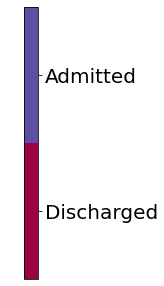

In [4]:
import matplotlib as mpl
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 1, figsize=[6,5])

fraction = 1  # .05

classes = ['Discharged',
          'Admitted']#,
          #'Discharged (Test)',
          #'Admitted (Test)']

values = np.arange(len(classes))

norm = mpl.colors.Normalize(vmin=values[0], vmax=values[-1])
cbar = ax.figure.colorbar(
            mpl.cm.ScalarMappable(norm=norm, cmap='Spectral'),
            boundaries=np.arange(len(classes)+1)-0.5,
            ax=ax, fraction=fraction)
cbar.set_ticks(np.arange(len(classes)))
cbar.set_ticklabels(classes)
cbar.ax.tick_params(labelsize=20)

ax.margins(0,0)

ax.axis('off')
plt.show()

#fig.savefig('Shortness/yale_short_colorbar.png', bbox_inches='tight')

In [5]:
sort_idx = []
sort_idx_tr = []

None


/home/ponir/.local/lib/python3.6/site-packages/numba/np/ufunc/parallel.py:363: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  warnings.warn(problem)


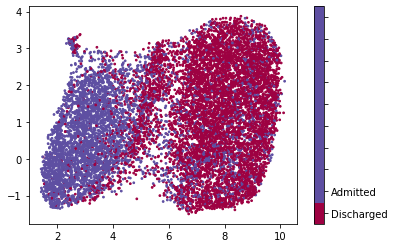

In [6]:
import umap

min_dist = 0.1

np.random.seed(100)
ump = umap.UMAP(n_neighbors=30,
        min_dist=0.1,
        n_components=2,
        random_state=100,
        metric= 'euclidean')

print(ump.n_epochs)

y_umap = ump.fit_transform(X_train)
y_umap_test = ump.transform(X_test)

plt.figure()
plt.scatter(y_umap[:,0], y_umap[:,1], c=y_train, s=3.0, cmap='Spectral')

cbar = plt.colorbar(boundaries=np.arange(11)-0.5)
cbar.set_ticks(np.arange(10))
cbar.set_ticklabels(classes)

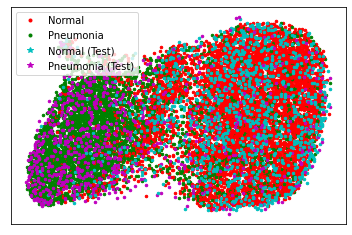

In [7]:
plot_umap(y_umap, y_train, y_umap_test, y_test,
              rot_angle = 0, x_neg = 1, y_neg = 1,
              filename='pneu_umap.png', if_legend=True, loc='upper left')

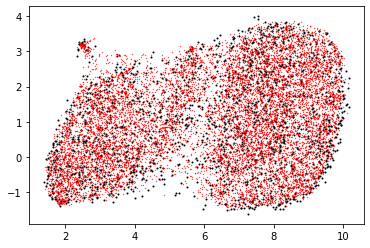

In [8]:
y_all = np.concatenate((np.zeros(X_train.shape[0]), np.ones(X_test.shape[0])))
#plt.figure(figsize=(15,15))

plt.figure()
c1 = 'k'
c2 = 'r'
plt.scatter(y_umap_test[:,0], y_umap_test[:,1], c=c1, s=1)
plt.scatter(y_umap[:,0], y_umap[:,1], c=c2, s=0.1)


classes_tr = ['train', 'test']


In [9]:
def get_indexes(ys, xr, yr):
    
    N1 = len(ys)
    
    idxs = []
    
    for i in range(N1):
        idx_in = True
        if ys[i][0] < xr[0] or ys[i][0] > xr[1]:
            idx_in = False
        if ys[i][1] < yr[0] or ys[i][1] > yr[1]:
            idx_in = False
        
        if idx_in:
            idxs.append(i)
            
    return idxs

idxs_outside = get_indexes(y_umap_test, xr=[6.57, 8.55], yr=[-1.49, -1.32])

print(idxs_outside, len(idxs_outside))

idxs_inside = get_indexes(y_umap_test, xr=[6.57, 8.55], yr=[-1.1, -0.7])

print(idxs_inside, len(idxs_inside))


idxs_outside2 = get_indexes(y_umap_test, xr=[9.7, 10], yr=[0.1, 0.8])

print(idxs_outside2, len(idxs_outside2))

idxs_inside2 = get_indexes(y_umap_test, xr=[9.5, 9.6], yr=[0.1, 0.8])

print(idxs_inside2, len(idxs_inside2))


idxs_outside3 = get_indexes(y_umap_test, xr=[1.35, 1.54], yr=[-1.0, 0.2])

print(idxs_outside3, len(idxs_outside3))

idxs_inside3 = get_indexes(y_umap_test, xr=[1.65, 1.74], yr=[-1.0, 0.2])

print(idxs_inside3, len(idxs_inside3))

[160, 222, 227, 238, 260, 279, 317, 324, 395, 480, 581, 686, 714, 741, 761, 808, 930, 1024, 1060, 1144, 1184, 1228, 1305, 1349, 1459, 1627, 1660, 1685, 1803, 1852, 1896, 1992] 32
[15, 129, 190, 244, 385, 490, 615, 640, 656, 678, 814, 849, 908, 953, 962, 995, 997, 1069, 1078, 1094, 1221, 1300, 1413, 1460, 1524, 1531, 1723, 1766, 1821, 1849, 1892, 1952] 32
[52, 117, 425, 580, 674, 1039, 1165, 1180, 1576, 1786, 1929] 11
[19, 42, 393, 795, 890, 1133, 1140, 1209, 1215, 1354, 1632] 11
[90, 159, 472, 857, 1177, 1270, 1338, 1663, 1694, 1756, 1829, 1893, 1902] 13
[174, 194, 388, 401, 497, 689, 965, 970, 992, 1125, 1150, 1791, 1970] 13


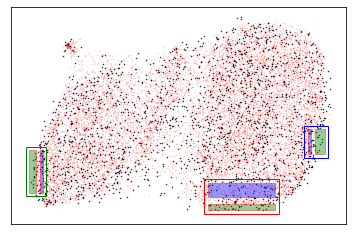

In [10]:
from matplotlib.collections import PatchCollection
from matplotlib.patches import Rectangle

DPI = 400

ar = 6.4/4.8

#plt.figure()
fig, ax = plt.subplots()

def plot_this(ax, alpha_value=0.4):
    c1 = 'k'
    c2 = 'r'
    plt.scatter(y_umap_test[:,0], y_umap_test[:,1], c=c1, s=0.2)
    plt.scatter(y_umap[:,0], y_umap[:,1], c=c2, s=0.1, alpha=0.3)

    box1_0 = Rectangle([6.57, -1.49], abs(6.57-8.55), abs(-1.49--1.32), linewidth=1, edgecolor='r', facecolor='g', alpha=alpha_value)
    ax.add_patch(box1_0)

    box1_i = Rectangle([6.57, -1.11], abs(6.57-8.55), abs(-1.1--0.7), linewidth=1, edgecolor='r', facecolor='b', alpha=alpha_value)
    ax.add_patch(box1_i)

    box2_0 = Rectangle([9.7, 0.1], abs(9.7-10), abs(0.1-0.8), linewidth=1, edgecolor='r', facecolor='g', alpha=alpha_value)
    ax.add_patch(box2_0)

    box2_i = Rectangle([9.5, 0.1],abs(9.5-9.6), abs(0.1-0.8), linewidth=1, edgecolor='r', facecolor='b', alpha=alpha_value)
    ax.add_patch(box2_i)


    box3_0 = Rectangle([1.35, -1.0], abs(1.35-1.54), abs(-1.0-0.2), linewidth=1, edgecolor='r', facecolor='g', alpha=alpha_value)
    ax.add_patch(box3_0)


    box3_i = Rectangle([1.65, -1.0], abs(1.65-1.74), abs(-1.0-0.2), linewidth=1, edgecolor='r', facecolor='b', alpha=alpha_value)
    ax.add_patch(box3_i)

    
plot_this(ax)


plt.xticks([])
plt.yticks([])

inset_1 = Rectangle([6.47, -1.59], abs(6.47-8.65), abs(-1.59--0.6), linewidth=1, edgecolor='r', facecolor='none')
ax.add_patch(inset_1)




inset_2 = Rectangle([9.4, 0.0], abs(9.4-10.1), abs(0.0-0.9), linewidth=1, edgecolor='b', facecolor='none')
ax.add_patch(inset_2)
 

inset_3 = Rectangle([1.25, -1.1], abs(1.25-1.85), abs(-1.1-0.3), linewidth=1, edgecolor='g', facecolor='none')
ax.add_patch(inset_3)


plt.savefig('Pneumonia_FIGURES/pneumonia_rfr_afr_places.png', bbox_inches='tight', dpi=DPI)
z = 0

In [11]:
def get_weight_function(dists, rho, sigma):
    d = dists - rho
    #print(d)
    d[d<0] = 0
    weight = np.exp(- d / sigma )
    #print(max(d))
    return weight


def search_sigma(dists, rho, k, tol = 10**-5, n_iteration=200):
    sigma_min = 0
    sigma_max = 1000
    
    cur_sigma = 100
    
    logk = np.log2(k)
    #print(logk)
    
    for i in range(n_iteration):
        
        cur_sigma = (sigma_min+sigma_max)/2
        probs = get_weight_function(dists,rho,cur_sigma)
        weight = np.sum(probs)
        #print(weight)
        
        if np.abs(logk - weight) < tol:
            break
        
        if weight < logk:
            sigma_min = cur_sigma
        else:
            sigma_max = cur_sigma
        
    return cur_sigma, probs


def get_ab(MIN_DIST):

    x = np.linspace(0, 3, 300)
    y = np.exp(- (x-MIN_DIST) * ( (x - MIN_DIST) >=0 ) )

    dist_low_dim = lambda x, a, b: 1 / (1 + a*x**(2*b))

    p , _ = optimize.curve_fit(dist_low_dim, x, y)

    a = p[0]
    b = p[1] 
    #print("Hyperparameters a = " + str(a) + " and b = " + str(b))

    return a, b


def nearest_neighbors_search(x, x_train, y, y_train, n_neighbors, min_dist):
    
    dist = np.sqrt(np.sum((x_train-x)**2,axis=1))
    sort_idx = np.argsort(dist)
    rho = dist[sort_idx[0]]
    x_dists = dist[sort_idx[:n_neighbors]]
    
    y_diff = y_train[sort_idx[:n_neighbors]]-y
    y_dists = np.sqrt(np.sum(( y_diff )**2,axis=1))
    
    
    #print(dist[:15])
    #print(np.sort(dist)[:15])
    #print(dist[sort_idx[:15]])
    
    sigma, weight = search_sigma(dists = x_dists,rho = rho,k = n_neighbors)
    
    a,b = get_ab(min_dist)
    
    
    ps = weight
    qs = 1 / ( 1 + a * (y_dists) ** b )
    
    #print(ps)
    #print(qs)
    
    pos_loss = np.log(ps/qs+10**-10)
    neg_loss = np.log((1-ps)/(1-qs)+10**-10)
    
    ratio = np.sum(pos_loss/neg_loss)
    
    
    attraction_forces = 2*a*b*y_dists**(b-1.0) / (1 + a * y_dists**b)
    aforces = 0
    af_sum = 0
    
    repulsion_forces = 2 * b / ( y_dists * (1.0 + a * y_dists**b) )
    rforces = 0
    rf_sum = 0
    
    for i in range(len(repulsion_forces)):
        rforces += repulsion_forces[i] * y_diff[i] * (1-ps[i])
        rf_sum += np.sum((repulsion_forces[i] * y_diff[i])**2)
        
        #print(repulsion_forces[i] * y_diff[i], rforces, np.sum((repulsion_forces[i] * y_diff[i])**2), rf_sum)
        #print(forces)
        aforces += attraction_forces[i] * y_diff[i] * ps[i]
        af_sum += np.sum((attraction_forces[i] * y_diff[i])**2)
        
    repulsion_force = np.sum(rforces**2)/len(repulsion_forces)
    attraction_force = np.sum(aforces**2)/len(attraction_forces)
    
    
    #print(ratio,repulsion_force, attraction_force)
    #print(rforces, rf_sum)
    
    return ratio, repulsion_force, attraction_force

ratio, repulsion_force, attraction_force = nearest_neighbors_search(X_test[0,:], X_train, 
                                    y_umap_test[0,:], y_umap, 
                                    n_neighbors=30, min_dist=min_dist)

<h1>n_s=3</h1>

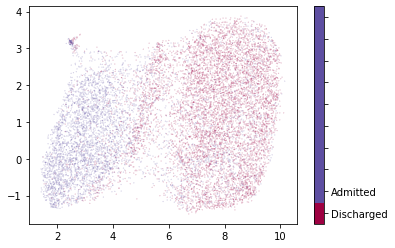

In [15]:
import umap

np.random.seed(100)
ump = umap.UMAP(n_neighbors=30,
        min_dist=min_dist,
        n_components=2,
        random_state=150,
        metric= 'euclidean')

y_umap_3 = ump.fit_transform(X_train)
ump.negative_sample_rate = 3
y_umap_test_3 = ump.transform(X_test)

plt.figure()
plt.scatter(y_umap[:,0], y_umap[:,1], c=y_train, s=0.01, cmap='Spectral')

cbar = plt.colorbar(boundaries=np.arange(11)-0.5)
cbar.set_ticks(np.arange(10))
cbar.set_ticklabels(classes)

<h1>UMAP ALL</h1>

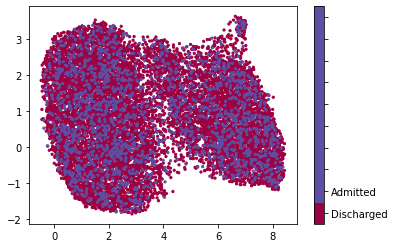

In [19]:
import umap

np.random.seed(100)
ump = umap.UMAP(n_neighbors=30,
        min_dist=0.1,
        n_components=2,
        random_state=100,
        metric= 'euclidean')

t_umap_all = ump.fit_transform(X_all)

y_all = np.concatenate((np.zeros(X_train.shape[0]), np.ones(X_test.shape[0])))

t_umap_all_train_n = t_umap_all[:X_train.shape[0]]
t_umap_all_test_n = t_umap_all[X_train.shape[0]:]

plt.figure()
plt.scatter(t_umap_all[:,0], t_umap_all[:,1], c=y_all, s=5, cmap='Spectral')

cbar = plt.colorbar(boundaries=np.arange(11)-0.5)
cbar.set_ticks(np.arange(10))
cbar.set_ticklabels(classes)

In [20]:
t_umap_all_train = t_umap_all_train_n #* multiplier
t_umap_all_test = t_umap_all_test_n #* multiplier



<h1>P-UMAP-CE</h1>

In [24]:
from scipy.io import loadmat

d = loadmat('nets_pneumonia_UMAP_CE/test_data39.mat')
t_ce_n = d['Y'].copy()
t_ce_test_n = d['Y_test'].copy()
t_ce_tr_te_n = np.concatenate((d['Y'],d['Y_test'])).copy()


In [25]:
t_ce = t_ce_n #* multiplier
t_ce_test = t_ce_test_n #* multiplier


<h1>Analyzin All</h1>

In [29]:
idxs_out_all = np.concatenate((idxs_outside, idxs_outside2, idxs_outside3))
idxs_in_all = np.concatenate((idxs_inside, idxs_inside2, idxs_inside3))

print(len(idxs_out_all), len(idxs_in_all))

56 56


Points Outside: 
Points inside
ns==5
AFR 2: 1.1291528704619351 abs:  0.12915287046193513
RFR 2: 1.7361794174232275 abs:  0.7361794174232275
(56, 2)
[]


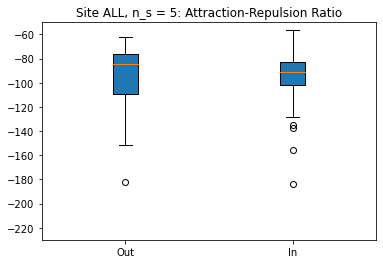

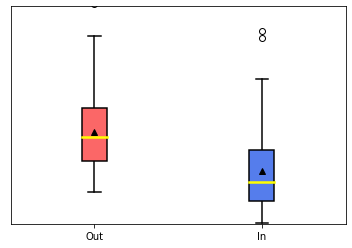

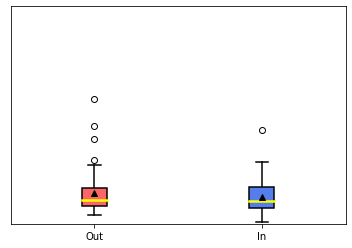

In [30]:
print('Points Outside: ')

idxs_out = idxs_out_all
idxs_in = idxs_in_all

ratios_outside = []
rf_outside = []
af_outside = []
for i in range(len(idxs_out)):
    ratio, repulsion_forces, attraction_force = nearest_neighbors_search(X_test[idxs_out[i],:], X_train, 
                                    y_umap_test[idxs_out[i],:], y_umap, 
                                    n_neighbors=30, min_dist=min_dist)
    
    ratios_outside.append(ratio)
    rf_outside.append(repulsion_forces)
    af_outside.append(attraction_force)

    
print('Points inside')
ratios_inside = []
rf_inside = []
af_inside = []
for i in range(len(idxs_in)):
    ratio, repulsion_forces, attraction_force = nearest_neighbors_search(X_test[idxs_in[i],:], X_train, 
                                    y_umap_test[idxs_in[i],:], y_umap, 
                                    n_neighbors=30, min_dist=min_dist)
    ratios_inside.append(ratio)
    rf_inside.append(repulsion_forces)
    af_inside.append(attraction_force)


rf_outside = np.array(rf_outside)
rf_inside = np.array(rf_inside)

af_outside = np.array(af_outside)
af_inside = np.array(af_inside)
    
ratios = np.array([ratios_outside, ratios_inside]).T
rf_all = np.array([rf_outside, rf_inside]).T
af_all = np.array([af_outside, af_inside]).T


rfr_2 = np.sum(rf_outside)/np.sum(rf_inside)

afr_2 = np.sum(af_outside)/np.sum(af_inside)

print('ns==5')
print('AFR 2:', afr_2, 'abs: ', abs(1-afr_2))
print('RFR 2:', rfr_2, 'abs: ', abs(1-rfr_2))


print(ratios.shape)

print(sort_idx)

tick_labels = ['Out', 'In']
colors = ['#fb6767', '#557dec']

plt.figure()
bp1 = plt.boxplot(ratios,
                  vert=True,  
                  patch_artist=True, 
                  labels=tick_labels)
plt.ylim([-230,-50])
plt.title('Site ALL, n_s = 5: Attraction-Repulsion Ratio')

plt.figure()
bp2 = plt.boxplot(rf_all,
                  vert=True,  
                  patch_artist=True, 
                  labels=tick_labels,
                  showmeans = True,
                  meanprops = dict(markeredgecolor='k',markerfacecolor='k'),
                  whiskerprops = dict(linewidth=1.5),
                  capprops = dict(linewidth=1.5),
                  boxprops = dict(linewidth=1.5),
                  medianprops=dict(color='yellow', linewidth=2.5))
for patch, color in zip(bp2['boxes'], colors):
    patch.set_facecolor(color)
plt.ylim([0, 15])
plt.yticks([])

#plt.title('Site ALL, n_s = 5: Repulsion Forces')
#plt.xticks([1, 2], ['Out', 'In'])
plt.savefig('pneu_fig_boxplot/bx_pneu_rf_UMAP_ns5.png', dpi=DPI, bbox_inches='tight')

plt.figure()
bp3 = plt.boxplot(af_all,
                  vert=True,  
                  patch_artist=True, 
                  labels=tick_labels,
                  showmeans = True,
                  meanprops = dict(markeredgecolor='k',markerfacecolor='k'),
                  whiskerprops = dict(linewidth=1.5),
                  capprops = dict(linewidth=1.5),
                  boxprops = dict(linewidth=1.5),
                  medianprops=dict(color='yellow', linewidth=2.5))
for patch, color in zip(bp3['boxes'], colors):
    patch.set_facecolor(color)
plt.ylim([0, 2])
plt.yticks([])
#plt.title('Site ALL, n_s = 5: Attraction Forces')
plt.xticks([1, 2], ['Out', 'In'])
plt.savefig('pneu_fig_boxplot/bx_pneu_af_UMAP_ns5.png', dpi=DPI, bbox_inches='tight')

Points Outside: 
Points inside
ns=3
AFR 2: 1.0968541909805773 abs:  0.09685419098057735
RFR 2: 2.8538739774727526 abs:  1.8538739774727526
(56, 2)
[]


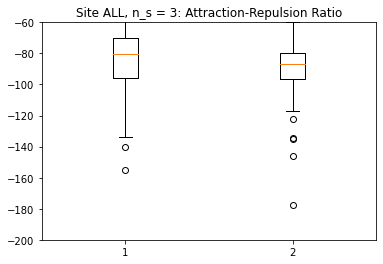

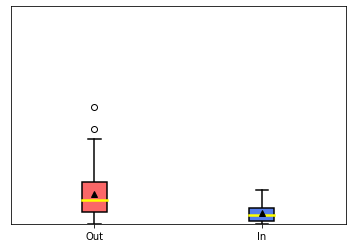

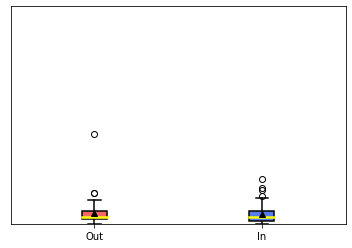

In [31]:
print('Points Outside: ')

idxs_out = idxs_out_all
idxs_in = idxs_in_all

ratios_outside = []
rf_outside = []
af_outside = []
for i in range(len(idxs_out)):
    ratio, repulsion_forces, attraction_force = nearest_neighbors_search(X_test[idxs_out[i],:], X_train, 
                                    y_umap_test_3[idxs_out[i],:], y_umap_3, 
                                    n_neighbors=30, min_dist=min_dist)
    
    ratios_outside.append(ratio)
    rf_outside.append(repulsion_forces)
    af_outside.append(attraction_force)

    
print('Points inside')
ratios_inside = []
rf_inside = []
af_inside = []
for i in range(len(idxs_in)):
    ratio, repulsion_forces, attraction_force = nearest_neighbors_search(X_test[idxs_in[i],:], X_train, 
                                    y_umap_test_3[idxs_in[i],:], y_umap_3, 
                                    n_neighbors=30, min_dist=min_dist)
    ratios_inside.append(ratio)
    rf_inside.append(repulsion_forces)
    af_inside.append(attraction_force)

ratios = np.array([ratios_outside, ratios_inside]).T
rf_all = np.array([rf_outside, rf_inside]).T
af_all = np.array([af_outside, af_inside]).T

rf_outside = np.array(rf_outside)
rf_inside = np.array(rf_inside)

af_outside = np.array(af_outside)
af_inside = np.array(af_inside)
    
ratios = np.array([ratios_outside, ratios_inside]).T
rf_all = np.array([rf_outside, rf_inside]).T
af_all = np.array([af_outside, af_inside]).T


rfr_2 = np.sum(rf_outside)/np.sum(rf_inside)

afr_2 = np.sum(af_outside)/np.sum(af_inside)

print('ns=3')
print('AFR 2:', afr_2, 'abs: ', abs(1-afr_2))
print('RFR 2:', rfr_2, 'abs: ', abs(1-rfr_2))

print(ratios.shape)

print(sort_idx)

plt.figure()
plt.boxplot(ratios)
plt.ylim([-200,-60])
plt.title('Site ALL, n_s = 3: Attraction-Repulsion Ratio')

plt.figure()
bp2 = plt.boxplot(rf_all,
                  vert=True,  
                  patch_artist=True, 
                  labels=tick_labels,
                  showmeans = True,
                  meanprops = dict(markeredgecolor='k',markerfacecolor='k'),
                  whiskerprops = dict(linewidth=1.5),
                  capprops = dict(linewidth=1.5),
                  boxprops = dict(linewidth=1.5),
                  medianprops=dict(color='yellow', linewidth=2.5))
for patch, color in zip(bp2['boxes'], colors):
    patch.set_facecolor(color)
plt.ylim([0, 15])
plt.yticks([])
#plt.title('Site ALL, n_s = 3: Repulsion Forces')
plt.xticks([1, 2], ['Out', 'In'])
plt.savefig('pneu_fig_boxplot/bx_pneu_rf_UMAP_ns3.png', dpi=DPI, bbox_inches='tight')

plt.figure()
bp3 = plt.boxplot(af_all,
                  vert=True,  
                  patch_artist=True, 
                  labels=tick_labels,
                  showmeans = True,
                  meanprops = dict(markeredgecolor='k',markerfacecolor='k'),
                  whiskerprops = dict(linewidth=1.5),
                  capprops = dict(linewidth=1.5),
                  boxprops = dict(linewidth=1.5),
                  medianprops=dict(color='yellow', linewidth=2.5))
for patch, color in zip(bp3['boxes'], colors):
    patch.set_facecolor(color)
plt.ylim([0, 2])
plt.yticks([])
#plt.title('Site ALL, n_s = 3: Attraction Forces')
plt.xticks([1, 2], ['Out', 'In'])
plt.savefig('pneu_fig_boxplot/bx_pneu_af_UMAP_ns3.png', dpi=DPI, bbox_inches='tight')

Points Outside: 
Points inside
ns=1
AFR 2: 0.8326153197895025 abs:  0.16738468021049746
RFR 2: 1.4046177002503726 abs:  0.4046177002503726
(56, 2)
[]


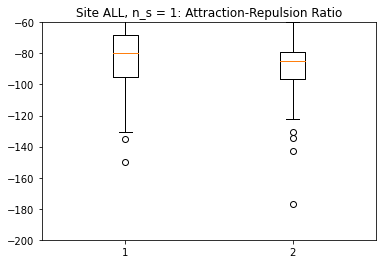

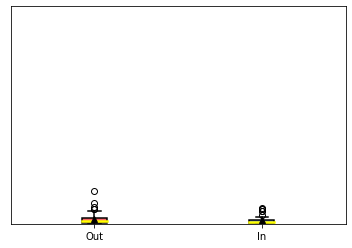

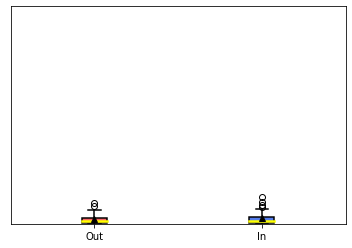

In [32]:
import umap

np.random.seed(100)
ump = umap.UMAP(n_neighbors=30,
        min_dist=min_dist,
        n_components=2,
        random_state=150,
        metric= 'euclidean')

y_umap_1 = ump.fit_transform(X_train)
ump.negative_sample_rate = 1
y_umap_test_1 = ump.transform(X_test)

print('Points Outside: ')

idxs_out = idxs_out_all
idxs_in = idxs_in_all

ratios_outside = []
rf_outside = []
af_outside = []
for i in range(len(idxs_out)):
    ratio, repulsion_forces, attraction_force = nearest_neighbors_search(X_test[idxs_out[i],:], X_train, 
                                    y_umap_test_1[idxs_out[i],:], y_umap_1, 
                                    n_neighbors=30, min_dist=min_dist)
    
    ratios_outside.append(ratio)
    rf_outside.append(repulsion_forces)
    af_outside.append(attraction_force)

    
print('Points inside')
ratios_inside = []
rf_inside = []
af_inside = []
for i in range(len(idxs_in)):
    ratio, repulsion_forces, attraction_force = nearest_neighbors_search(X_test[idxs_in[i],:], X_train, 
                                    y_umap_test_1[idxs_in[i],:], y_umap_1, 
                                    n_neighbors=30, min_dist=min_dist)
    ratios_inside.append(ratio)
    rf_inside.append(repulsion_forces)
    af_inside.append(attraction_force)

ratios = np.array([ratios_outside, ratios_inside]).T
rf_all = np.array([rf_outside, rf_inside]).T
af_all = np.array([af_outside, af_inside]).T

rf_outside = np.array(rf_outside)
rf_inside = np.array(rf_inside)

af_outside = np.array(af_outside)
af_inside = np.array(af_inside)

ratios = np.array([ratios_outside, ratios_inside]).T
rf_all = np.array([rf_outside, rf_inside]).T
af_all = np.array([af_outside, af_inside]).T


rfr_2 = np.sum(rf_outside)/np.sum(rf_inside)

afr_2 = np.sum(af_outside)/np.sum(af_inside)

print('ns=1')
print('AFR 2:', afr_2, 'abs: ', abs(1-afr_2))
print('RFR 2:', rfr_2, 'abs: ', abs(1-rfr_2))

print(ratios.shape)

print(sort_idx)

plt.figure()
plt.boxplot(ratios)
plt.ylim([-200,-60])
plt.title('Site ALL, n_s = 1: Attraction-Repulsion Ratio')

plt.figure()
bp2 = plt.boxplot(rf_all,
                  vert=True,  
                  patch_artist=True, 
                  labels=tick_labels,
                  showmeans = True,
                  meanprops = dict(markeredgecolor='k',markerfacecolor='k'),
                  whiskerprops = dict(linewidth=1.5),
                  capprops = dict(linewidth=1.5),
                  boxprops = dict(linewidth=1.5),
                  medianprops=dict(color='yellow', linewidth=2.5))
for patch, color in zip(bp2['boxes'], colors):
    patch.set_facecolor(color)
plt.ylim([0, 15])
plt.yticks([])
#plt.title('Site ALL, n_s = 3: Repulsion Forces')
plt.xticks([1, 2], ['Out', 'In'])
plt.savefig('pneu_fig_boxplot/bx_pneu_rf_UMAP_ns1.png', dpi=DPI, bbox_inches='tight')

plt.figure()
bp3 = plt.boxplot(af_all,
                  vert=True,  
                  patch_artist=True, 
                  labels=tick_labels,
                  showmeans = True,
                  meanprops = dict(markeredgecolor='k',markerfacecolor='k'),
                  whiskerprops = dict(linewidth=1.5),
                  capprops = dict(linewidth=1.5),
                  boxprops = dict(linewidth=1.5),
                  medianprops=dict(color='yellow', linewidth=2.5))
for patch, color in zip(bp3['boxes'], colors):
    patch.set_facecolor(color)
plt.ylim([0, 2])
plt.yticks([])
#plt.title('Site ALL, n_s = 3: Attraction Forces')
plt.xticks([1, 2], ['Out', 'In'])
plt.savefig('pneu_fig_boxplot/bx_pneu_af_UMAP_ns1.png', dpi=DPI, bbox_inches='tight')

Points Outside: 
Points inside
UMAP_ALL
AFR 2: 1.0765596478386328 abs:  0.07655964783863278
RFR 2: 1.107146079686959 abs:  0.107146079686959
(56, 2)
[]


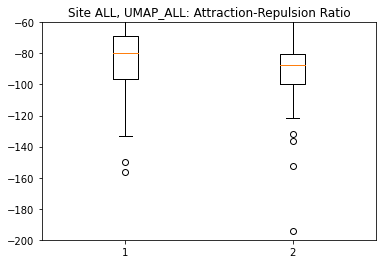

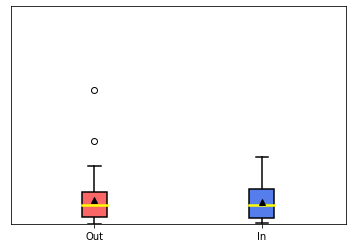

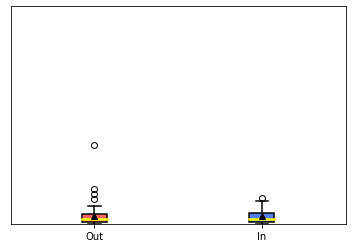

In [33]:
print('Points Outside: ')

idxs_out = idxs_out_all
idxs_in = idxs_in_all

ratios_outside = []
rf_outside = []
af_outside = []
for i in range(len(idxs_out)):
    ratio, repulsion_forces, attraction_force = nearest_neighbors_search(X_test[idxs_out[i],:], X_train, 
                                    t_umap_all_test[idxs_out[i],:], t_umap_all_train, 
                                    n_neighbors=30, min_dist=min_dist)
    
    ratios_outside.append(ratio)
    rf_outside.append(repulsion_forces)
    af_outside.append(attraction_force)

    
print('Points inside')
ratios_inside = []
rf_inside = []
af_inside = []
for i in range(len(idxs_in)):
    ratio, repulsion_forces, attraction_force = nearest_neighbors_search(X_test[idxs_in[i],:], X_train, 
                                    t_umap_all_test[idxs_in[i],:], t_umap_all_train, 
                                    n_neighbors=30, min_dist=min_dist)
    ratios_inside.append(ratio)
    rf_inside.append(repulsion_forces)
    af_inside.append(attraction_force)

ratios = np.array([ratios_outside, ratios_inside]).T
rf_all = np.array([rf_outside, rf_inside]).T
af_all = np.array([af_outside, af_inside]).T

rf_outside = np.array(rf_outside)
rf_inside = np.array(rf_inside)

af_outside = np.array(af_outside)
af_inside = np.array(af_inside)
    
ratios = np.array([ratios_outside, ratios_inside]).T
rf_all = np.array([rf_outside, rf_inside]).T
af_all = np.array([af_outside, af_inside]).T


rfr_2 = np.sum(rf_outside)/np.sum(rf_inside)

afr_2 = np.sum(af_outside)/np.sum(af_inside)

print('UMAP_ALL')
print('AFR 2:', afr_2, 'abs: ', abs(1-afr_2))
print('RFR 2:', rfr_2, 'abs: ', abs(1-rfr_2))

print(ratios.shape)

print(sort_idx)

plt.figure()
plt.boxplot(ratios)
plt.ylim([-200,-60])
plt.title('Site ALL, UMAP_ALL: Attraction-Repulsion Ratio')

plt.figure()
bp2 = plt.boxplot(rf_all,
                  vert=True,  
                  patch_artist=True, 
                  labels=tick_labels,
                  showmeans = True,
                  meanprops = dict(markeredgecolor='k',markerfacecolor='k'),
                  whiskerprops = dict(linewidth=1.5),
                  capprops = dict(linewidth=1.5),
                  boxprops = dict(linewidth=1.5),
                  medianprops=dict(color='yellow', linewidth=2.5))
for patch, color in zip(bp2['boxes'], colors):
    patch.set_facecolor(color)
plt.ylim([0, 15])
plt.yticks([])
#plt.title('Site ALL, n_s = 3: Repulsion Forces')
plt.xticks([1, 2], ['Out', 'In'])
plt.savefig('pneu_fig_boxplot/bx_pneu_rf_UMAP_all.png', dpi=DPI, bbox_inches='tight')

plt.figure()
bp3 = plt.boxplot(af_all,
                  vert=True,  
                  patch_artist=True, 
                  labels=tick_labels,
                  showmeans = True,
                  meanprops = dict(markeredgecolor='k',markerfacecolor='k'),
                  whiskerprops = dict(linewidth=1.5),
                  capprops = dict(linewidth=1.5),
                  boxprops = dict(linewidth=1.5),
                  medianprops=dict(color='yellow', linewidth=2.5))
for patch, color in zip(bp3['boxes'], colors):
    patch.set_facecolor(color)
plt.ylim([0, 2])
plt.yticks([])
#plt.title('Site ALL, n_s = 3: Attraction Forces')
plt.xticks([1, 2], ['Out', 'In'])
plt.savefig('pneu_fig_boxplot/bx_pneu_af_UMAP_all.png', dpi=DPI, bbox_inches='tight')

Points Outside: 
Points inside
UMAP_CE
AFR 2: 1.0764943774058444 abs:  0.07649437740584442
RFR 2: 1.3623643218864903 abs:  0.36236432188649026
(56, 2)
[]


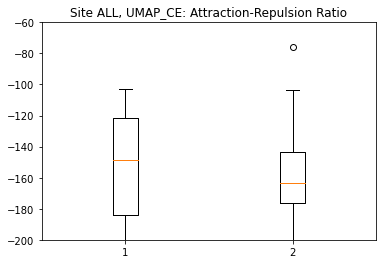

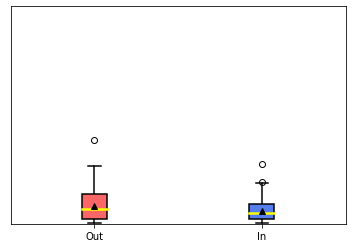

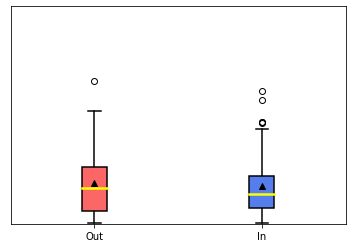

In [34]:
print('Points Outside: ')

idxs_out = idxs_out_all
idxs_in = idxs_in_all

ratios_outside = []
rf_outside = []
af_outside = []
for i in range(len(idxs_out)):
    ratio, repulsion_forces, attraction_force = nearest_neighbors_search(X_test[idxs_out[i],:], X_train, 
                                    t_ce_test[idxs_out[i],:], t_ce, 
                                    n_neighbors=30, min_dist=min_dist)
    
    ratios_outside.append(ratio)
    rf_outside.append(repulsion_forces)
    af_outside.append(attraction_force)

    
print('Points inside')
ratios_inside = []
rf_inside = []
af_inside = []
for i in range(len(idxs_in)):
    ratio, repulsion_forces, attraction_force = nearest_neighbors_search(X_test[idxs_in[i],:], X_train, 
                                    t_ce_test[idxs_in[i],:], t_ce, 
                                    n_neighbors=30, min_dist=min_dist)
    ratios_inside.append(ratio)
    rf_inside.append(repulsion_forces)
    af_inside.append(attraction_force)

ratios = np.array([ratios_outside, ratios_inside]).T
rf_all = np.array([rf_outside, rf_inside]).T
af_all = np.array([af_outside, af_inside]).T


rf_outside = np.array(rf_outside)
rf_inside = np.array(rf_inside)

af_outside = np.array(af_outside)
af_inside = np.array(af_inside)
    
ratios = np.array([ratios_outside, ratios_inside]).T
rf_all = np.array([rf_outside, rf_inside]).T
af_all = np.array([af_outside, af_inside]).T

rfr_2 = np.sum(rf_outside)/np.sum(rf_inside)

afr_2 = np.sum(af_outside)/np.sum(af_inside)

print('UMAP_CE')
print('AFR 2:', afr_2, 'abs: ', abs(1-afr_2))
print('RFR 2:', rfr_2, 'abs: ', abs(1-rfr_2))
print(ratios.shape)

print(sort_idx)

plt.figure()
plt.boxplot(ratios)
plt.ylim([-200,-60])
plt.title('Site ALL, UMAP_CE: Attraction-Repulsion Ratio')

plt.figure()
bp2 = plt.boxplot(rf_all,
                  vert=True,  
                  patch_artist=True, 
                  labels=tick_labels,
                  showmeans = True,
                  meanprops = dict(markeredgecolor='k',markerfacecolor='k'),
                  whiskerprops = dict(linewidth=1.5),
                  capprops = dict(linewidth=1.5),
                  boxprops = dict(linewidth=1.5),
                  medianprops=dict(color='yellow', linewidth=2.5))
for patch, color in zip(bp2['boxes'], colors):
    patch.set_facecolor(color)
plt.ylim([0, 15])
plt.yticks([])
#plt.title('Site ALL, n_s = 3: Repulsion Forces')
plt.xticks([1, 2], ['Out', 'In'])
plt.savefig('pneu_fig_boxplot/bx_pneu_rf_UMAP_CE.png', dpi=DPI, bbox_inches='tight')

plt.figure()
bp3 = plt.boxplot(af_all,
                  vert=True,  
                  patch_artist=True, 
                  labels=tick_labels,
                  showmeans = True,
                  meanprops = dict(markeredgecolor='k',markerfacecolor='k'),
                  whiskerprops = dict(linewidth=1.5),
                  capprops = dict(linewidth=1.5),
                  boxprops = dict(linewidth=1.5),
                  medianprops=dict(color='yellow', linewidth=2.5))
for patch, color in zip(bp3['boxes'], colors):
    patch.set_facecolor(color)
plt.ylim([0, 2])
plt.yticks([])
#plt.title('Site ALL, n_s = 3: Attraction Forces')
plt.xticks([1, 2], ['Out', 'In'])
plt.savefig('pneu_fig_boxplot/bx_pneu_af_UMAP_CE.png', dpi=DPI, bbox_inches='tight')

Points Outside: 
Points inside
UMAP_CE_MSE
AFR 2: 0.8465624821488358 abs:  0.15343751785116422
RFR 2: 1.2908427942675778 abs:  0.29084279426757775
(56, 2)
[]


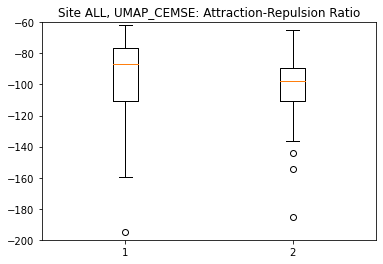

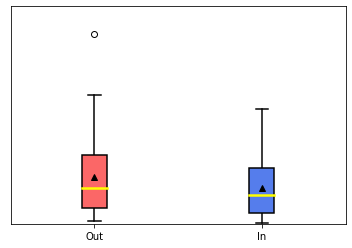

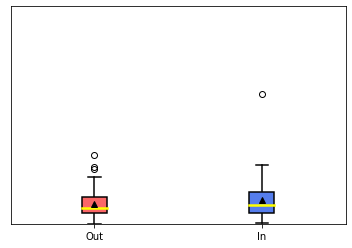

In [35]:
from scipy.io import loadmat

d = loadmat('nets_MSE_CE_UMAP_peumonia/test_data19.mat')
t_cemse_n = d['Y'].copy()
t_cemse_test_n = d['Y_test'].copy()
t_cemse_tr_te_n = np.concatenate((d['Y'],d['Y_test'])).copy()


print('Points Outside: ')

idxs_out = idxs_out_all
idxs_in = idxs_in_all

ratios_outside = []
rf_outside = []
af_outside = []
for i in range(len(idxs_out)):
    ratio, repulsion_forces, attraction_force = nearest_neighbors_search(X_test[idxs_out[i],:], X_train, 
                                    t_cemse_test_n[idxs_out[i],:], t_cemse_n, 
                                    n_neighbors=30, min_dist=min_dist)
    
    ratios_outside.append(ratio)
    rf_outside.append(repulsion_forces)
    af_outside.append(attraction_force)

    
print('Points inside')
ratios_inside = []
rf_inside = []
af_inside = []
for i in range(len(idxs_in)):
    ratio, repulsion_forces, attraction_force = nearest_neighbors_search(X_test[idxs_in[i],:], X_train, 
                                    t_cemse_test_n[idxs_in[i],:], t_cemse_n, 
                                    n_neighbors=30, min_dist=min_dist)
    ratios_inside.append(ratio)
    rf_inside.append(repulsion_forces)
    af_inside.append(attraction_force)

ratios = np.array([ratios_outside, ratios_inside]).T
rf_all = np.array([rf_outside, rf_inside]).T
af_all = np.array([af_outside, af_inside]).T


rf_outside = np.array(rf_outside)
rf_inside = np.array(rf_inside)

af_outside = np.array(af_outside)
af_inside = np.array(af_inside)
    
ratios = np.array([ratios_outside, ratios_inside]).T
rf_all = np.array([rf_outside, rf_inside]).T
af_all = np.array([af_outside, af_inside]).T

rfr_2 = np.sum(rf_outside)/np.sum(rf_inside)

afr_2 = np.sum(af_outside)/np.sum(af_inside)

print('UMAP_CE_MSE')
print('AFR 2:', afr_2, 'abs: ', abs(1-afr_2))
print('RFR 2:', rfr_2, 'abs: ', abs(1-rfr_2))

print(ratios.shape)

print(sort_idx)

plt.figure()
plt.boxplot(ratios)
plt.ylim([-200,-60])
plt.title('Site ALL, UMAP_CEMSE: Attraction-Repulsion Ratio')

plt.figure()
bp2 = plt.boxplot(rf_all,
                  vert=True,  
                  patch_artist=True, 
                  labels=tick_labels,
                  showmeans = True,
                  meanprops = dict(markeredgecolor='k',markerfacecolor='k'),
                  whiskerprops = dict(linewidth=1.5),
                  capprops = dict(linewidth=1.5),
                  boxprops = dict(linewidth=1.5),
                  medianprops=dict(color='yellow', linewidth=2.5))
for patch, color in zip(bp2['boxes'], colors):
    patch.set_facecolor(color)
plt.ylim([0, 15])
plt.yticks([])
#plt.title('Site ALL, n_s = 3: Repulsion Forces')
plt.xticks([1, 2], ['Out', 'In'])
plt.savefig('pneu_fig_boxplot/bx_pneu_rf_UMAP_CEMSE.png', dpi=DPI, bbox_inches='tight')

plt.figure()
bp3 = plt.boxplot(af_all,
                  vert=True,  
                  patch_artist=True, 
                  labels=tick_labels,
                  showmeans = True,
                  meanprops = dict(markeredgecolor='k',markerfacecolor='k'),
                  whiskerprops = dict(linewidth=1.5),
                  capprops = dict(linewidth=1.5),
                  boxprops = dict(linewidth=1.5),
                  medianprops=dict(color='yellow', linewidth=2.5))
for patch, color in zip(bp3['boxes'], colors):
    patch.set_facecolor(color)
plt.ylim([0, 2])
plt.yticks([])
#plt.title('Site ALL, n_s = 3: Attraction Forces')
plt.xticks([1, 2], ['Out', 'In'])
plt.savefig('pneu_fig_boxplot/bx_pneu_af_UMAP_CEMSE.png', dpi=DPI, bbox_inches='tight')

Points Outside: 
Points inside
UMAP_MSE
AFR 2: 0.829914201495061 abs:  0.170085798504939
RFR 2: 1.3581219964317917 abs:  0.35812199643179166
(56, 2)
[]


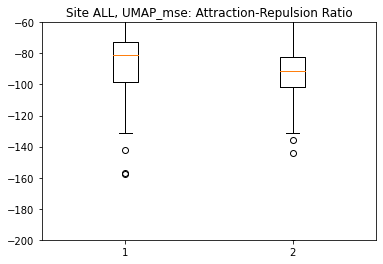

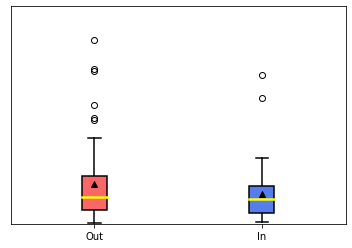

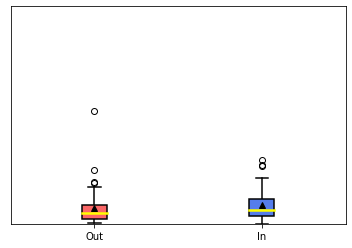

In [36]:
from scipy.io import loadmat

d = loadmat('nets_MSE_UMAP_pneumonia/test_data19.mat')
t_mse_n = d['Y'].copy()
t_mse_test_n = d['Y_test'].copy()
t_mse_tr_te_n = np.concatenate((d['Y'],d['Y_test'])).copy()


print('Points Outside: ')

idxs_out = idxs_out_all
idxs_in = idxs_in_all

ratios_outside = []
rf_outside = []
af_outside = []
for i in range(len(idxs_out)):
    ratio, repulsion_forces, attraction_force = nearest_neighbors_search(X_test[idxs_out[i],:], X_train, 
                                    t_mse_test_n[idxs_out[i],:], t_mse_n, 
                                    n_neighbors=30, min_dist=min_dist)
    
    ratios_outside.append(ratio)
    rf_outside.append(repulsion_forces)
    af_outside.append(attraction_force)

    
print('Points inside')
ratios_inside = []
rf_inside = []
af_inside = []
for i in range(len(idxs_in)):
    ratio, repulsion_forces, attraction_force = nearest_neighbors_search(X_test[idxs_in[i],:], X_train, 
                                    t_mse_test_n[idxs_in[i],:], t_mse_n, 
                                    n_neighbors=30, min_dist=min_dist)
    ratios_inside.append(ratio)
    rf_inside.append(repulsion_forces)
    af_inside.append(attraction_force)

ratios = np.array([ratios_outside, ratios_inside]).T
rf_all = np.array([rf_outside, rf_inside]).T
af_all = np.array([af_outside, af_inside]).T


rf_outside = np.array(rf_outside)
rf_inside = np.array(rf_inside)

af_outside = np.array(af_outside)
af_inside = np.array(af_inside)
    
ratios = np.array([ratios_outside, ratios_inside]).T
rf_all = np.array([rf_outside, rf_inside]).T
af_all = np.array([af_outside, af_inside]).T

rfr_2 = np.sum(rf_outside)/np.sum(rf_inside)

afr_2 = np.sum(af_outside)/np.sum(af_inside)

print('UMAP_MSE')
print('AFR 2:', afr_2, 'abs: ', abs(1-afr_2))
print('RFR 2:', rfr_2, 'abs: ', abs(1-rfr_2))

print(ratios.shape)

print(sort_idx)

plt.figure()
plt.boxplot(ratios)
plt.ylim([-200,-60])
plt.title('Site ALL, UMAP_mse: Attraction-Repulsion Ratio')

plt.figure()
bp2 = plt.boxplot(rf_all,
                  vert=True,  
                  patch_artist=True, 
                  labels=tick_labels,
                  showmeans = True,
                  meanprops = dict(markeredgecolor='k',markerfacecolor='k'),
                  whiskerprops = dict(linewidth=1.5),
                  capprops = dict(linewidth=1.5),
                  boxprops = dict(linewidth=1.5),
                  flierprops = dict(linewidth=1.5),
                  medianprops=dict(color='yellow', linewidth=2.5))
for patch, color in zip(bp2['boxes'], colors):
    patch.set_facecolor(color)
plt.ylim([0, 15])
plt.yticks([])
#plt.title('Site ALL, n_s = 3: Repulsion Forces')
plt.xticks([1, 2], ['Out', 'In'])
plt.savefig('pneu_fig_boxplot/bx_pneu_rf_UMAP_MSE.png', dpi=DPI, bbox_inches='tight')

plt.figure()
bp3 = plt.boxplot(af_all,
                  vert=True,  
                  patch_artist=True, 
                  labels=tick_labels,
                  showmeans = True,
                  meanprops = dict(markeredgecolor='k',markerfacecolor='k'),
                  whiskerprops = dict(linewidth=1.5),
                  capprops = dict(linewidth=1.5),
                  boxprops = dict(linewidth=1.5),
                  medianprops=dict(color='yellow', linewidth=2.5))
for patch, color in zip(bp3['boxes'], colors):
    patch.set_facecolor(color)
plt.ylim([0, 2])
plt.yticks([])
#plt.title('Site ALL, n_s = 3: Attraction Forces')
plt.xticks([1, 2], ['Out', 'In'])
plt.savefig('pneu_fig_boxplot/bx_pneu_af_UMAP_MSE.png', dpi=DPI, bbox_inches='tight')

<h1>Ablation Study</h1>

56 56
Starting index  0
Starting index  1
Starting index  2
Starting index  3
Starting index  4
Starting index  5
Starting index  6


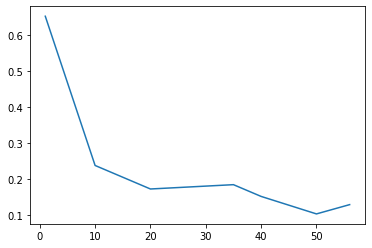

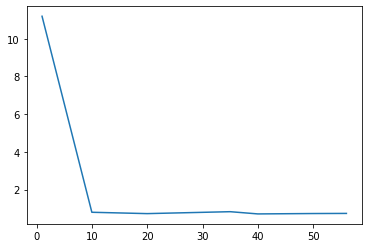

In [37]:
#idxs_out_all
#idxs_in_all
print(len(idxs_out_all), len(idxs_in_all))

seed = 9089
np.random.seed(seed)

Ns =       [1, 10,20,35,40,50,56]
N_samples =[10,10,10,10,10,10,1 ]
AFR_N_s = []
RFR_N_s = []

for i in range(len(Ns)):
    print('Starting index ', i)
    N_s = Ns[i]
    N_sample = N_samples[i]
    
    afrs = []
    rfrs = []
    
    
    for j in range(N_sample):
        idxs_out = np.random.choice(idxs_out_all,N_s,replace=False)
        idxs_in = np.random.choice(idxs_in_all,N_s,replace=False) #idxs_in_all

        ratios_outside = []
        rf_outside = []
        af_outside = []
        for i in range(len(idxs_out)):
            ratio, repulsion_forces, attraction_force = nearest_neighbors_search(X_test[idxs_out[i],:], X_train, 
                                            y_umap_test[idxs_out[i],:], y_umap, 
                                            n_neighbors=30, min_dist=min_dist)

            ratios_outside.append(ratio)
            rf_outside.append(repulsion_forces)
            af_outside.append(attraction_force)


        #print('Points inside')
        ratios_inside = []
        rf_inside = []
        af_inside = []
        for i in range(len(idxs_in)):
            ratio, repulsion_forces, attraction_force = nearest_neighbors_search(X_test[idxs_in[i],:], X_train, 
                                            y_umap_test[idxs_in[i],:], y_umap, 
                                            n_neighbors=30, min_dist=min_dist)
            ratios_inside.append(ratio)
            rf_inside.append(repulsion_forces)
            af_inside.append(attraction_force)


        rf_outside = np.array(rf_outside)
        rf_inside = np.array(rf_inside)

        af_outside = np.array(af_outside)
        af_inside = np.array(af_inside)

        ratios = np.array([ratios_outside, ratios_inside]).T
        rf_all = np.array([rf_outside, rf_inside]).T
        af_all = np.array([af_outside, af_inside]).T


        rfr_2 = np.sum(rf_outside)/np.sum(rf_inside)
        rfrs.append(rfr_2)

        afr_2 = np.sum(af_outside)/np.sum(af_inside)
        afrs.append(afr_2)
    if len(afrs)==1:
        afrs = afrs*10
        rfrs = rfrs*10
    
    AFR_N_s.append(afrs)
    RFR_N_s.append(rfrs)

AFR_N_s_UMAP = np.array(AFR_N_s)
RFR_N_s_UMAP = np.array(RFR_N_s)

AFR_2UMAP = np.abs(1-AFR_N_s_UMAP)
RFR_2UMAP = np.abs(1-RFR_N_s_UMAP)

AFR_2_mUMAP = np.mean(AFR_2UMAP,axis=1)
RFR_2_mUMAP = np.mean(RFR_2UMAP,axis=1)

AFR_2_stdUMAP = np.std(AFR_2UMAP,axis=1)
RFR_2_stdUMAP = np.std(RFR_2UMAP,axis=1)

plt.figure()
plt.plot(Ns, AFR_2_mUMAP)

plt.figure()
plt.plot(Ns, RFR_2_mUMAP)


56 56
Starting index  0
Starting index  1
Starting index  2
Starting index  3
Starting index  4
Starting index  5
Starting index  6


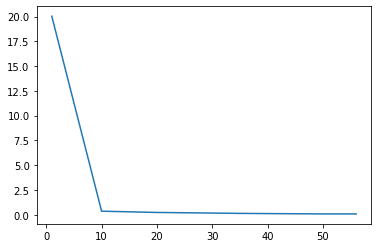

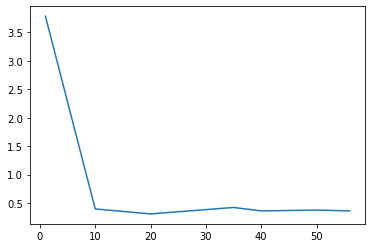

In [38]:
#idxs_out_all
#idxs_in_all
print(len(idxs_out_all), len(idxs_in_all))

seed = 9089
np.random.seed(seed)

AFR_N_s = []
RFR_N_s = []

for i in range(len(Ns)):
    print('Starting index ', i)
    N_s = Ns[i]
    N_sample = N_samples[i]
    
    afrs = []
    rfrs = []
    
    
    for j in range(N_sample):
        idxs_out = np.random.choice(idxs_out_all,N_s,replace=False)
        idxs_in = np.random.choice(idxs_in_all,N_s,replace=False) #idxs_in_all

        ratios_outside = []
        rf_outside = []
        af_outside = []
        for i in range(len(idxs_out)):
            ratio, repulsion_forces, attraction_force = nearest_neighbors_search(X_test[idxs_out[i],:], X_train, 
                                            t_ce_test[idxs_out[i],:], t_ce,
                                            n_neighbors=30, min_dist=min_dist)

            ratios_outside.append(ratio)
            rf_outside.append(repulsion_forces)
            af_outside.append(attraction_force)


        #print('Points inside')
        ratios_inside = []
        rf_inside = []
        af_inside = []
        for i in range(len(idxs_in)):
            ratio, repulsion_forces, attraction_force = nearest_neighbors_search(X_test[idxs_in[i],:], X_train, 
                                            t_ce_test[idxs_in[i],:], t_ce,
                                            n_neighbors=30, min_dist=min_dist)
            ratios_inside.append(ratio)
            rf_inside.append(repulsion_forces)
            af_inside.append(attraction_force)


        rf_outside = np.array(rf_outside)
        rf_inside = np.array(rf_inside)

        af_outside = np.array(af_outside)
        af_inside = np.array(af_inside)

        ratios = np.array([ratios_outside, ratios_inside]).T
        rf_all = np.array([rf_outside, rf_inside]).T
        af_all = np.array([af_outside, af_inside]).T


        rfr_2 = np.sum(rf_outside)/np.sum(rf_inside)
        rfrs.append(rfr_2)

        afr_2 = np.sum(af_outside)/np.sum(af_inside)
        afrs.append(afr_2)
    if len(afrs)==1:
        afrs = afrs*10
        rfrs = rfrs*10
    
    AFR_N_s.append(afrs)
    RFR_N_s.append(rfrs)

AFR_N_s_CE = np.array(AFR_N_s)
RFR_N_s_CE = np.array(RFR_N_s)

AFR_2CE = np.abs(1-AFR_N_s_CE)
RFR_2CE = np.abs(1-RFR_N_s_CE)

AFR_2_mCE = np.mean(AFR_2CE,axis=1)
RFR_2_mCE = np.mean(RFR_2CE,axis=1)

AFR_2_stdCE = np.std(AFR_2CE,axis=1)
RFR_2_stdCE = np.std(RFR_2CE,axis=1)

plt.figure()
plt.plot(Ns, AFR_2_mCE)

plt.figure()
plt.plot(Ns, RFR_2_mCE)


[0.65154692 0.23772881 0.17250075 0.18447733 0.15190509 0.10337159
 0.12915287]
[20.03682953  0.35228025  0.22502544  0.12867297  0.10995241  0.07617104
  0.07649438]


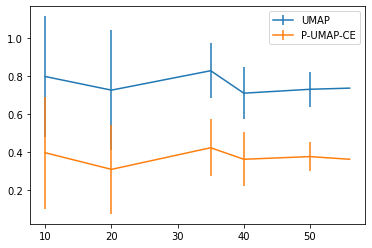

In [39]:
print(AFR_2_mUMAP)
print(AFR_2_mCE)
plt.figure()
plt.errorbar(Ns[1:], RFR_2_mUMAP[1:], yerr=RFR_2_stdUMAP[1:], label='UMAP')
plt.errorbar(Ns[1:], RFR_2_mCE[1:],   yerr=RFR_2_stdCE[1:],   label='P-UMAP-CE')
plt.legend()
